In [1]:
import os
import json
import glob
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import precision_recall_curve, roc_auc_score

In [2]:
base_log_dir = Path("../../yaib_logs")
log_dir = f'../../../data-addition-dilemma/distance_data'

In [3]:
hospital_ids = [73, 264, 420, 243, 338, 443, 199, 458, 300, 188, 252, 167]
hospital_dict = {} 
for i in range(len(hospital_ids)):
    hospital_dict[hospital_ids[i]] = i

## Aggregate experiment results

In [4]:
# aggregate experiment results

model = 'LogisticRegression'
log_dir = base_log_dir /  f'eicu/Mortality24/{model}'

df_rows = []

for i, hos in enumerate(hospital_ids): 
    
    dir_str = f"train-test{hos}-n1500"
    exp_dir = os.path.join(log_dir, dir_str)
    
    # get directory for most recent run
    files = os.listdir(exp_dir)
    files = [name for name in files if os.path.isdir(os.path.join(exp_dir, name)) and not name.startswith('.')] # folders only     
    paths = [os.path.join(exp_dir, basename) for basename in files]
    target_dir = max(paths, key=os.path.getctime)

    for rep in range(5):
        for fold in range(5):
            filename = os.path.join(target_dir, f'repetition_{rep}', f'fold_{fold}', 'patient_results.npz')
            data = np.load(filename)
            
            patient_ids = data["patient_ids"]
            predictions = data["predictions"]
            pred_labels = data["pred_labels"]
            true_labels = data["true_labels"]
            
            for pid, pred, pred_label, label in zip(patient_ids, predictions, pred_labels, true_labels):
                df_rows.append({
                    "repetition": rep,
                    "fold": fold,
                    "patient_id": pid,
                    "prediction": pred,
                    "pred_label": pred_label,
                    "true_label": label
                })

df = pd.DataFrame(df_rows)

In [5]:
# merge race data
df_demo = pd.read_parquet('../../YAIB-cohorts/data/mortality24/eicu/sta.parquet', engine='pyarrow')

patient_hospital = pd.read_csv('../../YAIB-cohorts/data/mortality24/eicu/patient_hospital.csv')
patient_hospital = patient_hospital.rename(columns={'patientunitstayid': 'stay_id'})

df_demo = df_demo.merge(patient_hospital[['stay_id', 'hospitalid']], on='stay_id', how='left')
df_demo = df_demo.rename(columns={'hospitalid': 'hosp_id'})

df = df.merge(df_demo[['stay_id', 'ethnic', 'hosp_id']], left_on='patient_id', right_on='stay_id', how='left')
df = df.drop(columns=['stay_id'])
df = df.dropna(subset='ethnic') # remove rows where ethnicity is unknown

In [6]:
# group by patient_id
min_samples = 2

df_grouped = df.groupby('patient_id').agg(
    hosp_id=('hosp_id', pd.Series.mode),
    count=('patient_id', 'size'),  # Count the occurrences of patient_id
    predictions=('prediction', lambda x: list(x)),
    pred_labels=('pred_label', lambda x: list(x)),
    avg_pred_label=('pred_label', 'mean'),  # Calculate the average value of pred_label
    ethnic=('ethnic', pd.Series.mode),
    true_label=('true_label', pd.Series.mode)
).reset_index()

df_grouped = df_grouped[df_grouped["count"] >= min_samples] # filter to only patients with >= MIN_SAMPLES

#summarize accuracy
accuracy_df = (
    df.assign(correct=(df["pred_label"] == df["true_label"]))  # Add a correctness column
    .groupby(["hosp_id", "ethnic"])["correct"]                # Group by hosp_id and ethnic
    .mean()                                                  # Compute mean accuracy
    .unstack(fill_value=0)                                   # Reshape to have ethnic as columns
)

# Add a column for the ethnic group with the minimum accuracy
accuracy_df["min_acc_subgroup"] = accuracy_df.idxmin(axis=1)

accuracy_df

In [8]:
mort_df = (
    df.assign(mort=(df["true_label"] == 1))  # Add a correctness column
    .groupby(["hosp_id", "ethnic"])["mort"]                # Group by hosp_id and ethnic
    .sum()                                                  # Compute mean accuracy                              # Reshape to have ethnic as columns
)

# Add a column for the ethnic group with the minimum accuracy
# mort_df["max_fnr_subgroup"] = fnr_df.idxmax(axis=1)

ethnic_counts = df.groupby(["hosp_id", "ethnic"]).size().reset_index(name="count")

# Display the result
mort_rates = pd.DataFrame(mort_df)["mort"].reset_index(drop=True) / ethnic_counts["count"].reset_index(drop=True)
mort_rates.index = pd.DataFrame(mort_df).index
mort_rates = pd.DataFrame(mort_rates)

mort_rates.columns = ["mort_rate"]
mort_rates = mort_rates.pivot_table(index="hosp_id", columns="ethnic", values="mort_rate", fill_value=0)

mort_rates["min_mort_ethnic"] = mort_rates.idxmin(axis=1)

mort_rates

ethnic,asian,black,other,white,min_rehosp_ethnic
hosp_id,,,,,
73,0.021583,0.027759,0.029412,0.014326,white
167,0.139535,0.081442,0.074247,0.087271,other
188,0.061538,0.057573,0.040892,0.065505,other
199,0.272727,0.041916,0.134409,0.058976,black
243,0.000000,0.030931,0.016611,0.021362,asian
252,0.407407,0.060907,0.074074,0.098202,black
264,0.012987,0.038462,0.074074,0.043645,asian
300,0.126437,0.073807,0.114754,0.050379,white
338,0.083333,0.034722,0.092559,0.054651,black


In [9]:
mort_all_df = (
    df.assign(mort=(df["true_label"] == 1))  # Add a correctness column
    .groupby(["ethnic"])["mort"]                # Group by hosp_id and ethnic
    .sum()                                                  # Compute mean accuracy                              # Reshape to have ethnic as columns
)

mort_all_df.reset_index(drop=True) /  df.groupby(["ethnic"]).size().reset_index(name="count")["count"]

0    0.083725
1    0.065327
2    0.074240
3    0.062179
dtype: float64

In [10]:
fnr_df = (
    df.assign(is_false_negative=(df["pred_label"] == 0) & (df["true_label"] == 1))  # Add a correctness column
    .groupby(["hosp_id", "ethnic"])["is_false_negative"]                # Group by hosp_id and ethnic
    .mean()                                                  # Compute mean accuracy
    .unstack(fill_value=0)                                   # Reshape to have ethnic as columns
)

# Add a column for the ethnic group with the minimum accuracy
fnr_df["max_fnr_subgroup"] = fnr_df.idxmax(axis=1)

# Display the result
fnr_df

ethnic,asian,black,other,white,max_fnr_subgroup
hosp_id,,,,,
73,0.007194,0.024455,0.021739,0.012299,black
167,0.100775,0.061415,0.052960,0.064202,asian
188,0.038462,0.039415,0.040892,0.045622,white
199,0.181818,0.017964,0.107527,0.046101,asian
243,0.000000,0.026467,0.006645,0.019040,black
252,0.333333,0.041076,0.050926,0.075455,asian
264,0.012987,0.036982,0.042328,0.038783,other
300,0.057471,0.049505,0.062842,0.037577,other
338,0.083333,0.027778,0.068966,0.041285,asian


## Analysis

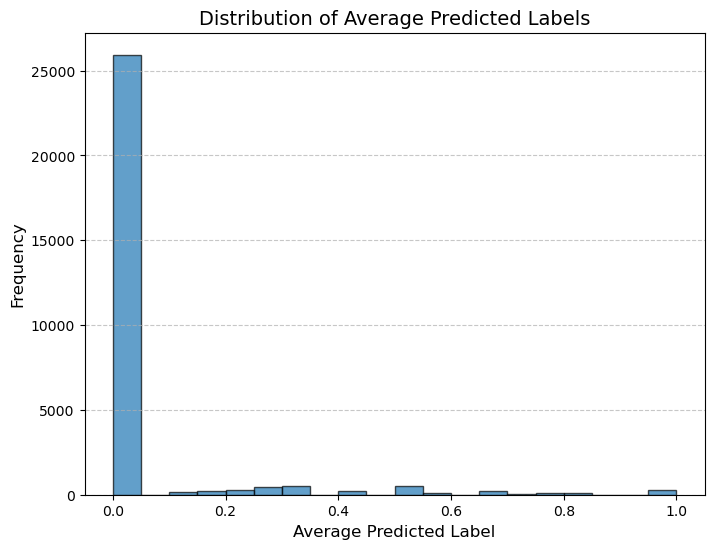

In [11]:
# distribution of agreement across all patients
plt.figure(figsize=(8, 6))
plt.hist(df_grouped['avg_pred_label'], bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribution of Average Predicted Labels', fontsize=14)
plt.xlabel('Average Predicted Label', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [12]:
# Filter out rows without arbitrariness
disagreement = 0

arbitrary_df = df_grouped[(df_grouped['avg_pred_label'] > disagreement) & (df_grouped['avg_pred_label'] < (1 - disagreement))]
print(f'Percent of arbitrary points: {arbitrary_df.shape[0] / df_grouped.shape[0]}')

Percent of arbitrary points: 0.0973704137123976


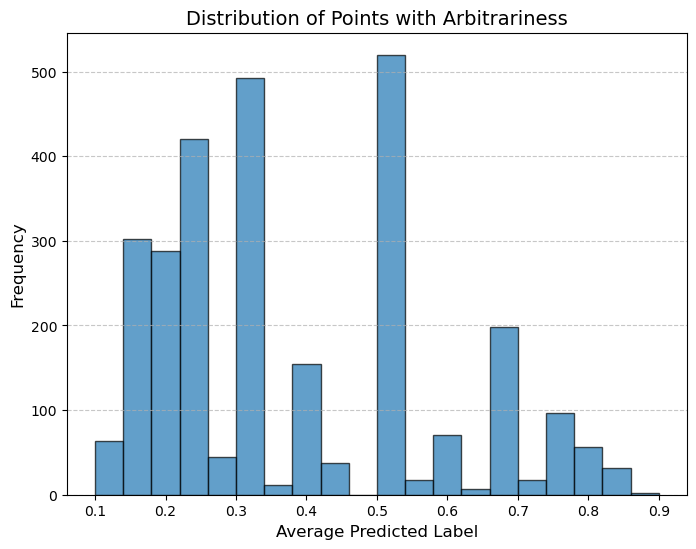

In [119]:
# distribution of agreement across all patients with arbitrariness
plt.figure(figsize=(8, 6))
plt.hist(arbitrary_df['avg_pred_label'], bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribution of Points with Arbitrariness', fontsize=14)
plt.xlabel('Average Predicted Label', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

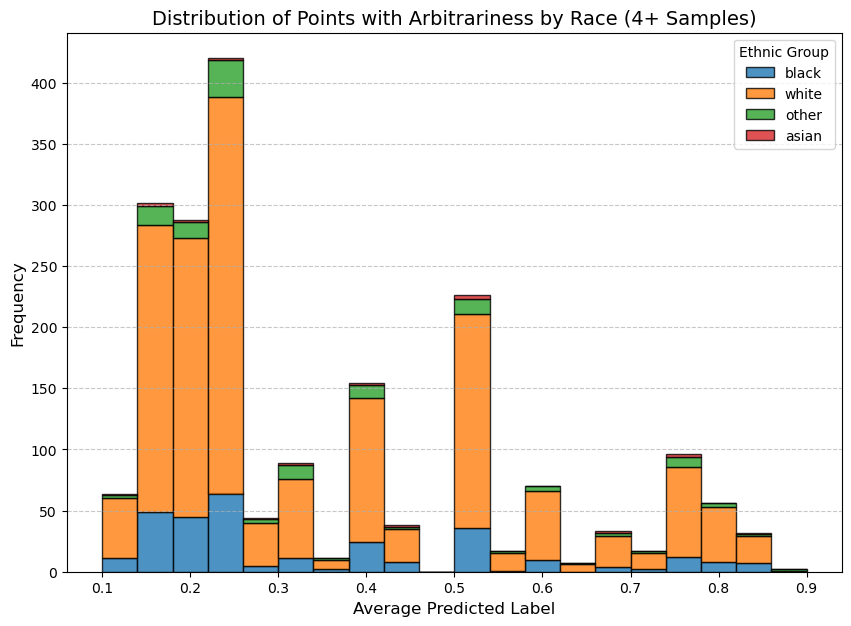

In [105]:
# Define the bins for the histogram
bins = np.linspace(arbitrary_df['avg_pred_label'].min(), arbitrary_df['avg_pred_label'].max(), 21)

# Create an empty dictionary to store counts for each ethnic group
ethnic_categories = arbitrary_df['ethnic'].unique()
ethnic_counts = {ethnic: [] for ethnic in ethnic_categories}

# Calculate the histogram for each ethnic group
for ethnic in ethnic_categories:
    ethnic_data = arbitrary_df[arbitrary_df['ethnic'] == ethnic]['avg_pred_label']
    counts, _ = np.histogram(ethnic_data, bins=bins)
    ethnic_counts[ethnic].append(counts)

# Stack the counts for the bar plot
stacked_counts = np.array([ethnic_counts[ethnic][0] for ethnic in ethnic_categories])

# Plot the stacked bar histogram
bin_centers = 0.5 * (bins[:-1] + bins[1:])
width = np.diff(bins)[0]  # Width of each bar

plt.figure(figsize=(10, 7))
bottom = np.zeros(len(bin_centers))  # Initialize the bottom for stacking

# Add each ethnic group's counts to the bar plot
for ethnic, counts in zip(ethnic_categories, stacked_counts):
    plt.bar(bin_centers, counts, width=width, label=f'{ethnic}', bottom=bottom, edgecolor='k', alpha=0.8)
    bottom += counts  # Update the bottom for the next segment

# Add labels and a legend
plt.title(f'Distribution of Points with Arbitrariness by Race ({min_samples}+ Samples)', fontsize=14)
plt.xlabel('Average Predicted Label', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(title='Ethnic Group')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

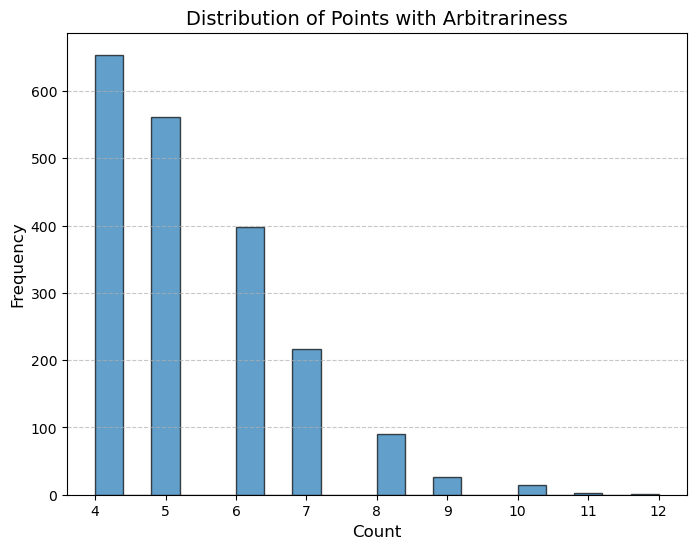

In [106]:
# distribution of sample count across all patients with arbitrariness
plt.figure(figsize=(8, 6))
plt.hist(arbitrary_df['count'], bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribution of Points with Arbitrariness', fontsize=14)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

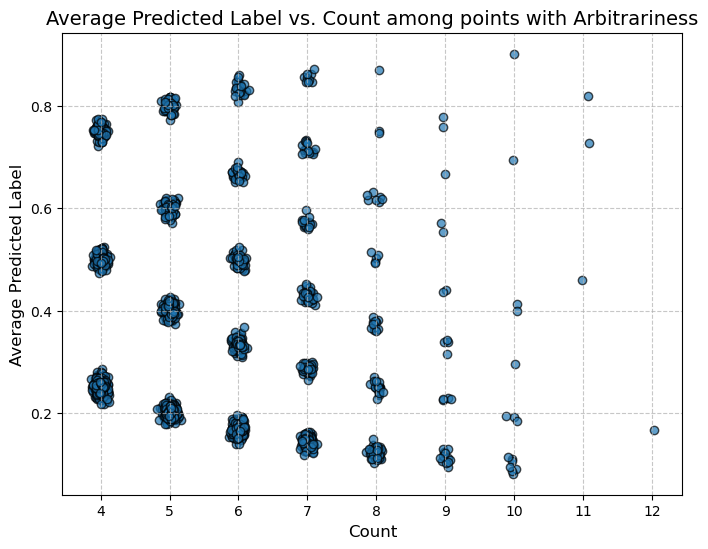

In [107]:
# Add jitter to both count and avg_pred_label for better visualization
jitter_strength_x = 0.05  # Adjust the horizontal jitter strength as needed
jitter_strength_y = 0.01  # Adjust the vertical jitter strength as needed
jittered_count = arbitrary_df['count'] + np.random.normal(0, jitter_strength_x, size=arbitrary_df['count'].shape)
jittered_pred = arbitrary_df['avg_pred_label'] + np.random.normal(0, jitter_strength_y, size=arbitrary_df['avg_pred_label'].shape)

plt.figure(figsize=(8, 6))
plt.scatter(jittered_count, jittered_pred, alpha=0.7, edgecolor='k')
plt.title('Average Predicted Label vs. Count among points with Arbitrariness', fontsize=14)
plt.ylabel('Average Predicted Label', fontsize=12)
plt.xlabel('Count', fontsize=12)
plt.grid(linestyle='--', alpha=0.7)
plt.show()

## Subgroup differences in arbitrariness

In [108]:
# base AUC by ethnicity
def compute_auc(group):
    if len(group['true_label'].unique()) > 1:  # Ensure both classes are present
        return roc_auc_score(group['true_label'], group['prediction'])
    else:
        return None  # AUC is not defined if only one class is present
    
auc_by_ethnic = (
    df
    .groupby('ethnic')
    .apply(compute_auc)
    .reset_index(name='auc')
)

auc_by_ethnic

,ethnic,auc
0,asian,0.899730
1,black,0.797354
2,other,0.797223
3,white,0.778842


In [109]:
arbitrary_df['ethnic'].value_counts() / df_grouped['ethnic'].value_counts()

ethnic
white    0.122245
black    0.113001
other    0.143659
asian    0.138686
Name: count, dtype: float64

In [110]:
# base AUC by ethnicity
def compute_auc(group):
    if len(group['true_label'].unique()) > 1:  # Ensure both classes are present
        return roc_auc_score(group['true_label'], group['avg_pred_label'])
    else:
        return None  # AUC is not defined if only one class is present
    
auc_by_ethnic = (
    df_grouped
    .groupby('ethnic')
    .apply(compute_auc)
    .reset_index(name='auc')
)

auc_by_ethnic

,ethnic,auc
0,asian,0.796667
1,black,0.699044
2,other,0.694744
3,white,0.673486


In [78]:
# get points where models are wrong more than half the time

wrong_idx = df_grouped['pred_labels'].apply(lambda x: pd.Series(x).mode().iloc[0] if len(pd.Series(x).mode()) > 0 else None)
wrong_df = df_grouped[wrong_idx != df_grouped['true_label']]

wrong_df['ethnic'].value_counts() / df_grouped['ethnic'].value_counts()

/tmp/ipykernel_1601734/2155105192.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arbitrary_df['prediction_range'] = arbitrary_df['predictions'].apply(lambda x: max(x) - min(x))


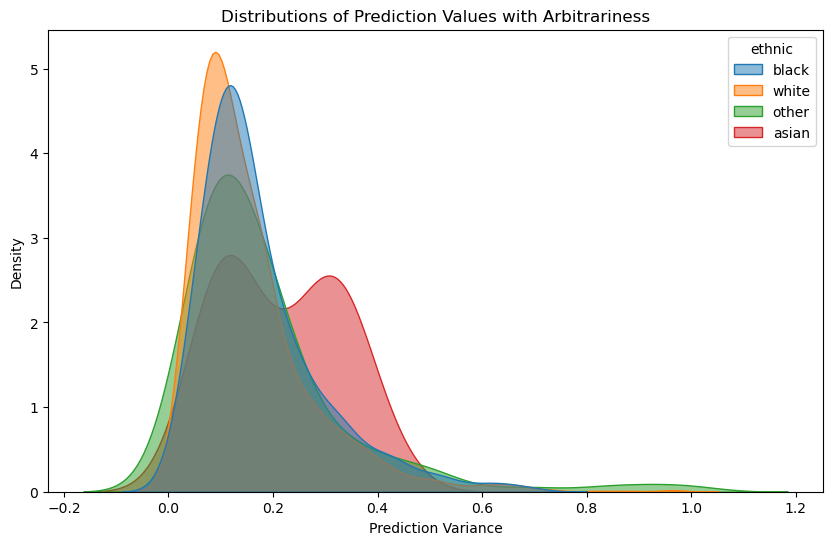

In [112]:
# Compute the range (max - min) for each patient's predictions
arbitrary_df['prediction_range'] = arbitrary_df['predictions'].apply(lambda x: max(x) - min(x))

# Plot overlapping distributions of prediction ranges by ethnic subgroup
plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=arbitrary_df,
    x='prediction_range',
    hue='ethnic',
    fill=True,
    common_norm=False,  # Allow subgroups to have their own normalization
    alpha=0.5
)

# Customize the plot
plt.title('Distributions of Prediction Values with Arbitrariness')
plt.xlabel('Prediction Variance')
plt.ylabel('Density')
plt.show()

## When are *all* models *always* wrong?

In [73]:
nonarb_df = df_grouped[(df_grouped['avg_pred_label'] == 0.0) | (df_grouped['avg_pred_label'] == 1.0)]

In [76]:
result = (
    nonarb_df
    .assign(correct=(nonarb_df['avg_pred_label'] != nonarb_df['true_label']))
    .groupby('ethnic')
    .agg(percent=('correct', 'mean'), count=('correct', 'sum'))
    .reset_index()
)

In [77]:
result

,ethnic,percent,count
0,asian,0.035242,8
1,black,0.044051,184
2,other,0.052206,71
3,white,0.045208,925


In [65]:
wrong_df['true_label'].value_counts() / df_grouped['true_label'].value_counts()

true_label
0.0    0.010713
1.0    0.233593
Name: count, dtype: float64

## Self-Consistency Ensembling

For each subgroup or (hospital, subgroup), compute the self-consistency as $$1 - \frac{2 \cdot B_0 \cdot B_1}{B (B-1)}$$

where 
- $B$ is the total number of predictions made
- $B_0$ is the total number of times the outputted prediction was $0$
- $B_1$ is the total number of times the outputted prediction was $1$

In [4]:
# aggregate experiment results

model = 'LogisticRegression'
log_dir = base_log_dir /  f'eicu/Mortality24/{model}'

df_rows = []

for i, hos in enumerate(hospital_ids): 
    for j, test_hos in enumerate(hospital_ids):
        if i == j:
            dir_str = f"train-test{hos}-n1500"
        else:
            dir_str = f"train{hos}-test{test_hos}-n1500"
        exp_dir = os.path.join(log_dir, dir_str)
        
        # get directory for most recent run
        files = os.listdir(exp_dir)
        files = [name for name in files if os.path.isdir(os.path.join(exp_dir, name)) and not name.startswith('.')] # folders only     
        paths = [os.path.join(exp_dir, basename) for basename in files]
        target_dir = max(paths, key=os.path.getctime)

        for rep in range(5):
            for fold in range(5):
                filename = os.path.join(target_dir, f'repetition_{rep}', f'fold_{fold}', 'patient_results.npz')
                data = np.load(filename)
                
                patient_ids = data["patient_ids"]
                predictions = data["predictions"]
                pred_labels = data["pred_labels"]
                true_labels = data["true_labels"]
                
                for pid, pred, pred_label, label in zip(patient_ids, predictions, pred_labels, true_labels):
                    df_rows.append({
                        "train_hos": hos,
                        "test_hos": test_hos,
                        "repetition": rep,
                        "fold": fold,
                        "patient_id": pid,
                        "prediction": pred,
                        "pred_label": pred_label,
                        "true_label": label
                    })

df = pd.DataFrame(df_rows)

In [5]:
# merge race data
df_demo = pd.read_parquet('../../YAIB-cohorts/data/mortality24/eicu/sta.parquet', engine='pyarrow')

patient_hospital = pd.read_csv('../../YAIB-cohorts/data/mortality24/eicu/patient_hospital.csv')
patient_hospital = patient_hospital.rename(columns={'patientunitstayid': 'stay_id'})

df_demo = df_demo.merge(patient_hospital[['stay_id', 'hospitalid']], on='stay_id', how='left')
df_demo = df_demo.rename(columns={'hospitalid': 'hosp_id'})

df = df.merge(df_demo[['stay_id', 'ethnic', 'hosp_id']], left_on='patient_id', right_on='stay_id', how='left')
df = df.drop(columns=['stay_id'])
df = df.dropna(subset='ethnic') # remove rows where ethnicity is unknown

In [6]:
# get per-hospital accuracy by taking majority vote without filtering for self-consistency
df0 = df[(df['repetition'] == 0) & (df['fold'] == 0)]

# Compute majority vote predictions for each (test_hos, patient_id)
majority_predictions = df0.groupby(['test_hos', 'patient_id'])['pred_label'].agg(lambda x: x.mode().iloc[0]).reset_index()

# Compute true labels for each (test_hos, patient_id)
true_labels = df0.groupby(['test_hos', 'patient_id'])['true_label'].first().reset_index()

# Merge majority predictions with true labels
merged = pd.merge(majority_predictions, true_labels, on=['test_hos', 'patient_id'])

# Add ethnic group information
merged = merged.merge(
    df0.groupby(['test_hos', 'patient_id'])['ethnic'].first().reset_index(), 
    on=['test_hos', 'patient_id']
)

# Calculate overall accuracy for each test hospital
test_hos_accuracy = merged.groupby('test_hos').apply(
    lambda x: (x['pred_label'] == x['true_label']).mean()
)

# Calculate subgroup accuracy for each test hospital and ethnic group
subgroup_accuracy = merged.groupby(['test_hos', 'ethnic']).apply(
    lambda x: (x['pred_label'] == x['true_label']).mean()
).reset_index()

# Pivot the subgroup accuracies
subgroup_pivot = subgroup_accuracy.pivot(index='test_hos', columns='ethnic', values=0)

# disparity = subgroup_pivot.max(axis=1) - subgroup_pivot.min(axis=1)

# Calculate the worst subgroup accuracy and corresponding ethnic group label
worst_subgroup = subgroup_pivot.idxmin(axis=1)  # Ethnicity with the lowest accuracy
worst_accuracy = subgroup_pivot.min(axis=1)    # Minimum accuracy value

# Combine overall accuracy with worst subgroup information
result_base = pd.DataFrame({
    'overall_accuracy': test_hos_accuracy,
    'worst_accuracy': worst_accuracy,
    'worst_ethnic_group': worst_subgroup
})

# Add the subgroup columns to the result
result_base = pd.concat([result_base, subgroup_pivot], axis=1)

# Rename the column to match your request
result_base.columns.name = None

print(result_base)

          overall_accuracy  worst_accuracy worst_ethnic_group     asian   
test_hos                                                                  
73                0.942181        0.843750              other  0.857143  \
167               0.909471        0.902153              white  0.909091   
188               0.940299        0.750000              asian  0.750000   
199               0.934337        0.846154              other  1.000000   
243               0.953395        0.920000              other  1.000000   
252               0.897507        0.500000              asian  0.500000   
264               0.957766        0.909091              other  1.000000   
300               0.957823        0.927711              black  1.000000   
338               0.890983        0.500000              asian  0.500000   
420               0.912000        0.909375              white  0.923077   
443               0.923288        0.666667              asian  0.666667   
458               0.89849

In [17]:
kappa = 0.6

def self_consistency(preds):
    B0 = (preds == 0).sum()
    B1 = (preds == 1).sum()
    B = len(preds)
    return 1 - 2 * B0 * B1 / (B * (B - 1)) if B > 1 else 1

# Compute self-consistency for each (test_hos, patient_id)
self_consistency_values = df0.groupby(['test_hos', 'patient_id'])['pred_label'].apply(self_consistency)

# Filter out rows where self-consistency is less than kappa
filtered_patients = self_consistency_values[self_consistency_values >= kappa].index

# Filter the original dataframe based on the filtered patients
df_filtered = df0[df0.set_index(['test_hos', 'patient_id']).index.isin(filtered_patients)]

# Compute majority vote predictions for each (test_hos, patient_id)
majority_predictions = df_filtered.groupby(['test_hos', 'patient_id'])['pred_label'].agg(lambda x: x.mode().iloc[0]).reset_index()

# Compute true labels for each (test_hos, patient_id)
true_labels = df_filtered.groupby(['test_hos', 'patient_id'])['true_label'].first().reset_index()

# Merge majority predictions with true labels
merged = pd.merge(majority_predictions, true_labels, on=['test_hos', 'patient_id'])

# Add ethnic group information
merged = merged.merge(
    df_filtered.groupby(['test_hos', 'patient_id'])['ethnic'].first().reset_index(),
    on=['test_hos', 'patient_id']
)

# Calculate overall accuracy for each test hospital
test_hos_accuracy = merged.groupby('test_hos').apply(
    lambda x: (x['pred_label'] == x['true_label']).mean()
)

# Calculate subgroup accuracy for each test hospital and ethnic group
subgroup_accuracy = merged.groupby(['test_hos', 'ethnic']).apply(
    lambda x: (x['pred_label'] == x['true_label']).mean()
).reset_index()

# Pivot the subgroup accuracies
subgroup_pivot = subgroup_accuracy.pivot(index='test_hos', columns='ethnic', values=0)

# Calculate disparity (max - min accuracy across subgroups)
# disparity = subgroup_pivot.max(axis=1) - subgroup_pivot.min(axis=1)

# Calculate the worst subgroup accuracy and corresponding ethnic group label
worst_subgroup = subgroup_pivot.idxmin(axis=1)  # Ethnicity with the lowest accuracy
worst_accuracy = subgroup_pivot.min(axis=1)    # Minimum accuracy value

# Combine overall accuracy with worst subgroup information
result = pd.DataFrame({
    'overall_accuracy': test_hos_accuracy,
    'worst_accuracy': worst_accuracy,
    'worst_ethnic_group': worst_subgroup
})

# Add the subgroup columns to the result
result = pd.concat([result, subgroup_pivot], axis=1)

# Rename the column to match your request
result.columns.name = None

print(result)


          overall_accuracy  worst_accuracy worst_ethnic_group     asian   
test_hos                                                                  
73                0.946355        0.852459              other  0.857143  \
167               0.927220        0.918200              white  1.000000   
188               0.952924        0.920000              other  1.000000   
199               0.947750        0.875000              black  1.000000   
243               0.965326        0.920000              other  1.000000   
252               0.903650        0.500000              asian  0.500000   
264               0.957567        0.909091              other  1.000000   
300               0.962857        0.939394              other  1.000000   
338               0.898611        0.500000              asian  0.500000   
420               0.921596        0.909091              asian  0.909091   
443               0.935199        0.666667              asian  0.666667   
458               0.91982

In [18]:
result['worst_accuracy'] - result_base['worst_accuracy']

test_hos
73     0.008709
167    0.016048
188    0.170000
199    0.028846
243    0.000000
252    0.000000
264    0.000000
300    0.011683
338    0.000000
420   -0.000284
443    0.000000
458    0.018254
Name: worst_accuracy, dtype: float64

print(result['worst_ethnic_group'])
print(result_base['worst_ethnic_group'])

In [8]:

# Reset the index for easier manipulation
self_consistency_df = self_consistency_values.reset_index(name='self_consistency')

# Add a column indicating whether the patient_id is not self-consistent
self_consistency_df['not_self_consistent'] = self_consistency_df['self_consistency'] != 1

# Calculate the percentage of not self-consistent patient_id for each test_hos
not_consistent_percent = self_consistency_df.groupby('test_hos')['not_self_consistent'].mean()

# Create a dataframe to display the results
result = not_consistent_percent.reset_index(name='percent_not_self_consistent')

# Display the result
print(result)

    test_hos  percent_not_self_consistent
0         73                     0.174770
1        167                     0.136490
2        188                     0.207598
3        199                     0.217510
4        243                     0.193076
5        252                     0.188366
6        264                     0.164850
7        300                     0.191837
8        338                     0.135935
9        420                     0.148000
10       443                     0.198630
11       458                     0.159122


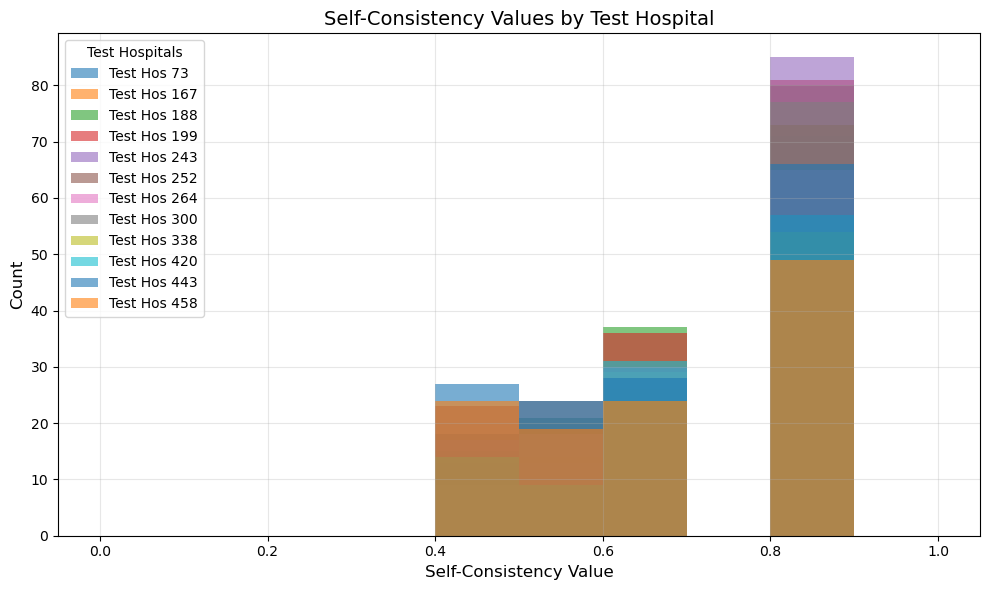

In [29]:
test_hos_groups = self_consistency_df[self_consistency_df['self_consistency'] != 1].groupby('test_hos')['self_consistency']

# Create a stacked histogram
plt.figure(figsize=(10, 6))
bins = [i * 0.1 for i in range(11)]  # Define bins from 0 to 1 with step of 0.1
for test_hos, values in test_hos_groups:
    plt.hist(values, bins=bins, label=f'Test Hos {test_hos}', alpha=0.6, stacked=False)

# Add plot details
plt.title('Self-Consistency Values by Test Hospital', fontsize=14)
plt.xlabel('Self-Consistency Value', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Test Hospitals', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()

# Show the plot
plt.show()